In [20]:
import pandas as pd
import json
import re
import warnings
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# NLTK Imports
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

# Sklearn Imports
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF, TruncatedSVD

# Gensim Imports
from gensim.models import Phrases

# Download necessary NLTK data (Run once)
try:
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('wordnet')
    nltk.download('averaged_perceptron_tagger')
    nltk.download('omw-1.4')
except:
    pass

warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to C:\Users\Ab-
[nltk_data]     Samrah\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Ab-
[nltk_data]     Samrah\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Ab-
[nltk_data]     Samrah\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Ab-Samrah\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.
[nltk_data] Downloading package omw-1.4 to C:\Users\Ab-
[nltk_data]     Samrah\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [21]:
mini_file_path = 'mini_hotel_reviews.json'
mini_data = []

# Load the JSON file
with open(mini_file_path, 'r', encoding='utf-8') as f:
    for line in f:
        try:
            mini_data.append(json.loads(line))
        except json.JSONDecodeError:
            pass

df = pd.DataFrame(mini_data)
print(f"Successfully loaded {len(df)} records.")

# smart check to find the text column
possible_columns = ['text', 'review', 'content', 'review_text', 'description']
text_column = next((col for col in possible_columns if col in df.columns), None)

if text_column:
    print(f"Using column '{text_column}' for analysis.")
else:
    print("Error: Could not find a text column. Please check df.columns")

Successfully loaded 10000 records.
Using column 'text' for analysis.


In [22]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

# Helper function for POS tagging
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def preprocess(text):
    if not isinstance(text, str):
        return ""
    
    # 1. Basic Cleaning
    text = text.lower()
    text = re.sub(r'http\S+', '', text) # Remove URLs
    text = re.sub(r'<.*?>', '', text)   # Remove HTML
    text = re.sub(r"[^a-zA-Z\s]", " ", text) # Remove punctuation/numbers
    text = re.sub(r'\s+', ' ', text).strip() # Remove extra spaces
    
    # 2. Tokenization
    tokens = nltk.word_tokenize(text)
    
    # 3. Stopwords Removal
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    
    # 4. Lemmatization with POS tagging
    tagged = pos_tag(tokens)
    lemmatized = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in tagged]
    
    return lemmatized  # Return list of tokens

# Apply Preprocessing
print("Preprocessing text... this may take a moment.")
if text_column:
    # Get list of tokens
    docs_tokens = [preprocess(doc) for doc in df[text_column]]

    # Create Bigrams (e.g., "new", "york" -> "new_york")
    bigram = Phrases(docs_tokens, min_count=3, threshold=5)
    bigram_mod = [bigram[doc] for doc in docs_tokens]

    # Join back to strings for Sklearn
    clean_docs = [" ".join(doc) for doc in bigram_mod]
    print("Preprocessing complete.")

Preprocessing text... this may take a moment.
Preprocessing complete.


In [23]:
# 1. Vectorization
print("Vectorizing...")
# Count Vectorizer (for LDA)
count_vectorizer = CountVectorizer(max_features=5000, max_df=0.95, min_df=2)
X_count = count_vectorizer.fit_transform(clean_docs)
feature_names_count = count_vectorizer.get_feature_names_out()

# TF-IDF Vectorizer (for NMF and LSA)
tfidf_vectorizer = TfidfVectorizer(max_features=5000, max_df=0.95, min_df=2)
X_tfidf = tfidf_vectorizer.fit_transform(clean_docs)
feature_names_tfidf = tfidf_vectorizer.get_feature_names_out()

# 2. Define Models
n_topics = 5 # You can change this number

lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42)
nmf_model = NMF(n_components=n_topics, random_state=42, init='nndsvd')
lsa_model = TruncatedSVD(n_components=n_topics, random_state=42)

# 3. Train Models
print("Training LDA...")
lda_model.fit(X_count)

print("Training NMF...")
nmf_model.fit(X_tfidf)

print("Training LSA...")
lsa_model.fit(X_tfidf)

# 4. Function to Display Topics
def display_topics(model, feature_names, no_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        topics[f"Topic {topic_idx}"] = " ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]])
    return topics

print("\n--- LDA Topics (Probabilistic) ---")
print(display_topics(lda_model, feature_names_count, 10))

print("\n--- NMF Topics (Distinct Themes) ---")
print(display_topics(nmf_model, feature_names_tfidf, 10))

print("\n--- LSA Topics (Semantic Concepts) ---")
print(display_topics(lsa_model, feature_names_tfidf, 10))

Vectorizing...
Training LDA...
Training NMF...
Training LSA...

--- LDA Topics (Probabilistic) ---
{'Topic 0': 'great place food get coffee breakfast good beer delicious love', 'Topic 1': 'get say go time would one order tell take come', 'Topic 2': 'place get like good pizza great store love look always', 'Topic 3': 'great room good place food bar drink hotel nice service', 'Topic 4': 'good food place order get great try like come delicious'}

--- NMF Topics (Distinct Themes) ---
{'Topic 0': 'get one go time say come would take place like', 'Topic 1': 'great love place food awesome service always best staff drink', 'Topic 2': 'pizza order crust topping cheese salad delivery place slice good', 'Topic 3': 'room hotel stay nice night staff location clean bed breakfast', 'Topic 4': 'good food service delicious order restaurant place burger chicken fry'}

--- LSA Topics (Semantic Concepts) ---
{'Topic 0': 'food place good great get order come service like one', 'Topic 1': 'great food good l

Visualizing NMF Topics:


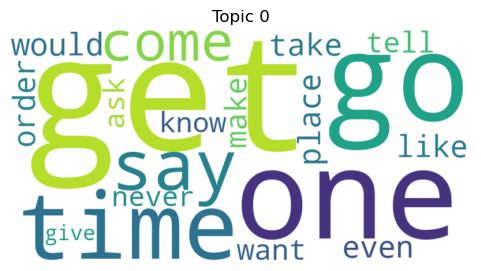

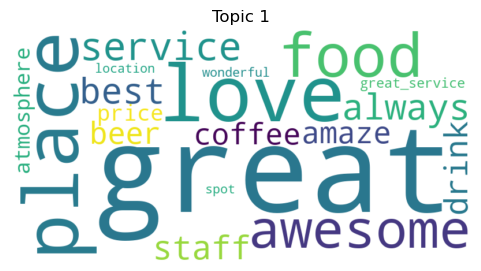

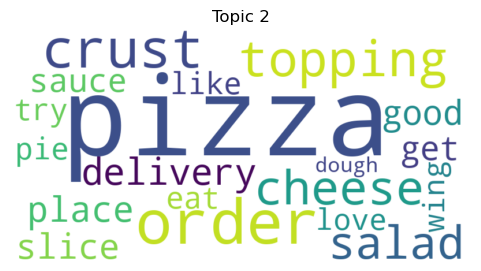

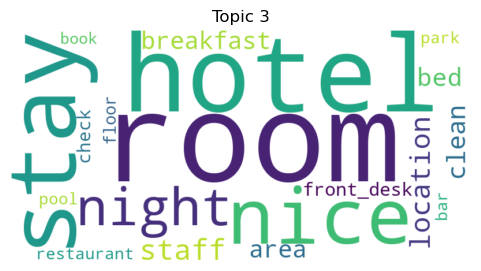

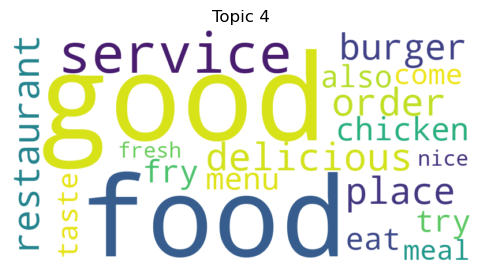

Visualizing LDA Topics:


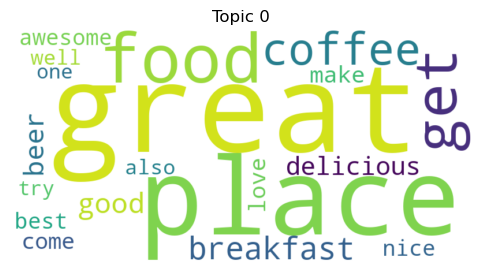

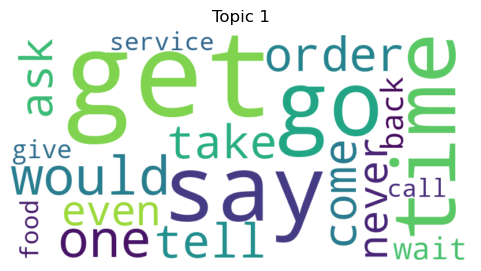

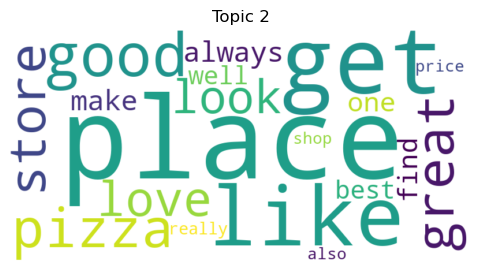

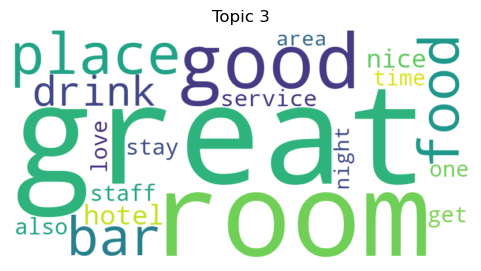

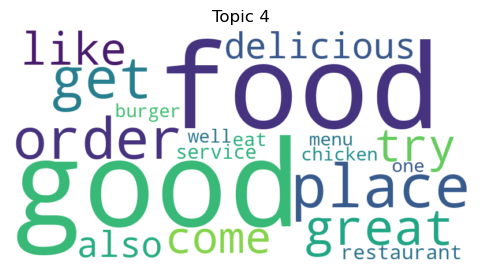

Visualizing NLSA Topics:


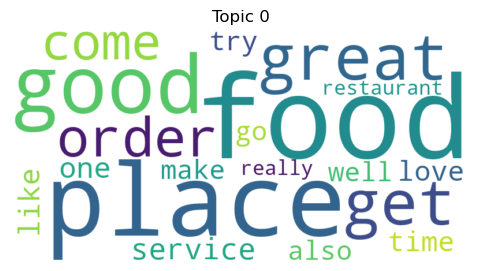

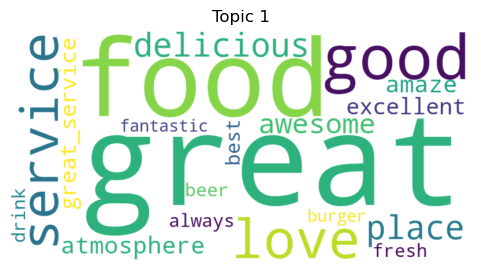

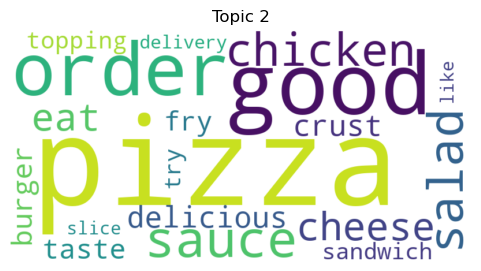

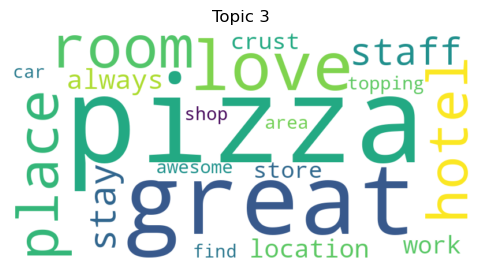

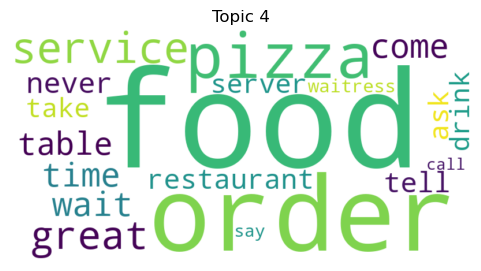

In [25]:
def plot_wordcloud(model, feature_names):
    for topic_idx, topic in enumerate(model.components_):
        freqs = {feature_names[i]: topic[i] for i in topic.argsort()[:-20:-1]}
        wc = WordCloud(background_color="white", width=800, height=400).generate_from_frequencies(freqs)
        
        plt.figure(figsize=(6,3))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")
        plt.title(f"Topic {topic_idx}")
        plt.show()

print("Visualizing NMF Topics:")
plot_wordcloud(nmf_model, feature_names_tfidf)

print("Visualizing LDA Topics:")
plot_wordcloud(lda_model, feature_names_tfidf)

print("Visualizing NLSA Topics:")
plot_wordcloud(lsa_model, feature_names_tfidf)

Visualizing NMF Topics:


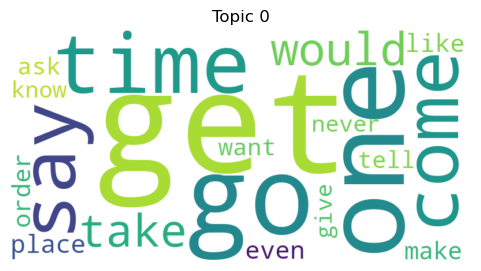

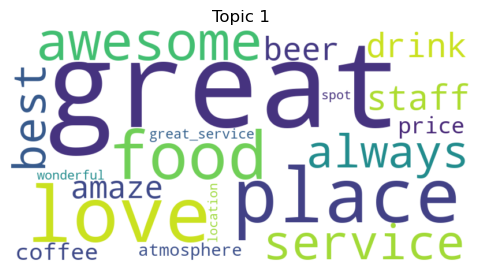

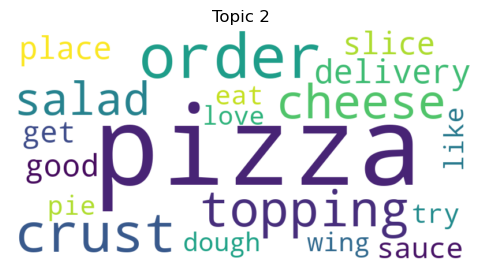

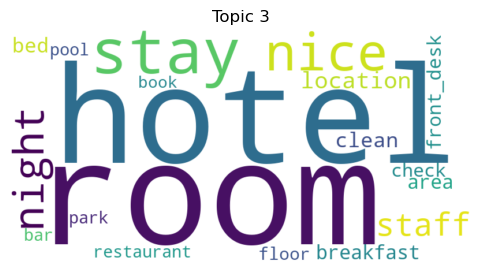

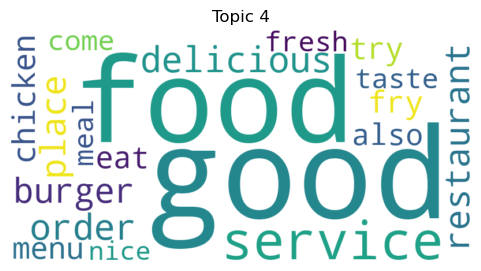

Visualizing LDA Topics:


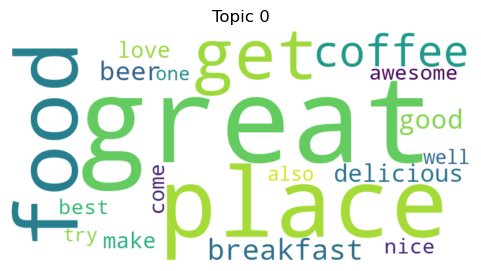

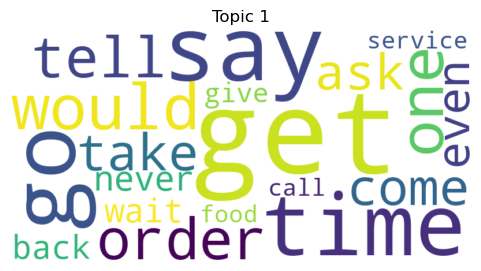

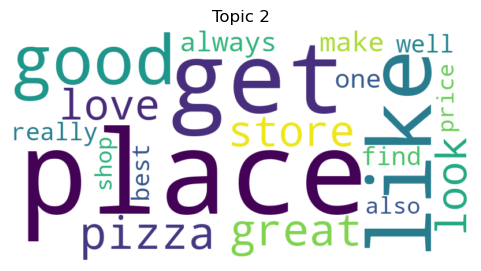

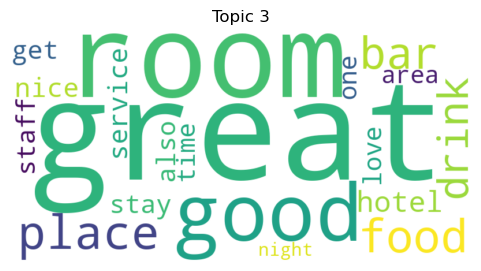

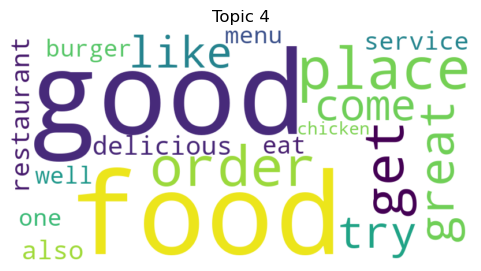

Visualizing LSA Topics:


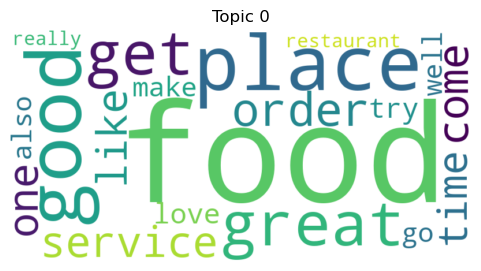

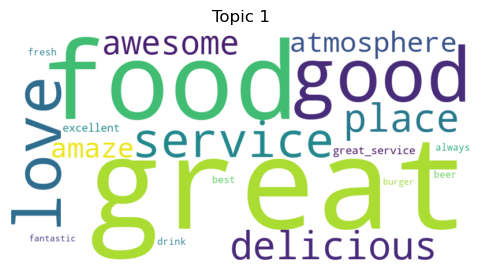

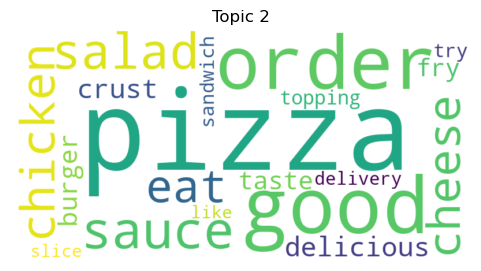

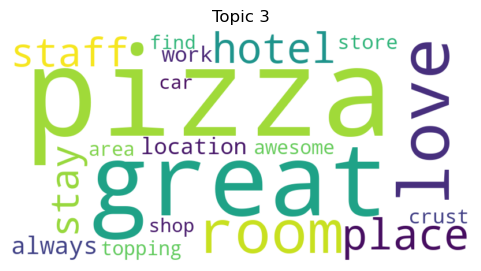

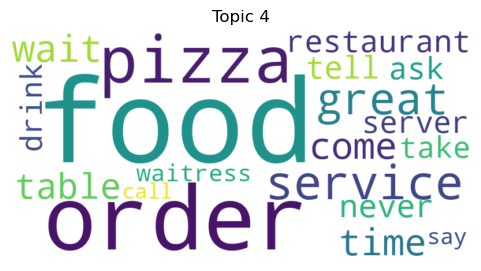

In [26]:
print("Visualizing NMF Topics:")
plot_wordcloud(nmf_model, feature_names_tfidf)

print("Visualizing LDA Topics:")
plot_wordcloud(lda_model, feature_names_tfidf)

print("Visualizing LSA Topics:")
plot_wordcloud(lsa_model, feature_names_tfidf)

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# ---------------------------------------------------------
# 1. Define the Target (Positive vs Negative)
# ---------------------------------------------------------
# We need to find the column with the rating. 
# Common names: 'rating', 'overall', 'stars', 'score'.
# REPLACE 'rating' below with the actual column name in your df if different.
rating_col = 'rating' 

# Check if column exists
if rating_col not in df.columns:
    # Try to auto-detect if user didn't change it
    possible = [c for c in df.columns if 'rate' in c or 'score' in c or 'star' in c]
    if possible:
        rating_col = possible[0]
        print(f"Found rating column: '{rating_col}'")
    else:
        raise ValueError("Could not find a rating column. Please specify 'rating_col' manually.")

# Create Binary Labels:
# 1 = Positive (Rating > 3)
# 0 = Negative (Rating <= 3)
# (You can adjust the threshold, e.g., drop neutral 3s)
df['sentiment'] = df[rating_col].apply(lambda x: 1 if float(x) > 3 else 0)

y = df['sentiment']
X = X_tfidf  # We use the TF-IDF result from the previous step

print("Target labels created.")
print(f"Positive samples: {sum(y)}")
print(f"Negative samples: {len(y) - sum(y)}")

Found rating column: 'stars'
Target labels created.
Positive samples: 7019
Negative samples: 2981


In [ ]:
# ---------------------------------------------------------
# 2. Split Data (Train/Test)
# ---------------------------------------------------------
# Split 70% for training, 30% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# ---------------------------------------------------------
# 3. Train Logistic Regression
# ---------------------------------------------------------
print("Training Logistic Regression Model...")
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# ---------------------------------------------------------
# 4. Evaluate
# ---------------------------------------------------------
# Predict on the test set
y_pred = log_reg.predict(X_test)

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy * 100:.2f}%")

# Detailed Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

# Show Confusion Matrix (True Positives vs False Positives)
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Training Logistic Regression Model...

Model Accuracy: 85.33%

Classification Report:
              precision    recall  f1-score   support

    Negative       0.87      0.59      0.70       885
    Positive       0.85      0.96      0.90      2115

    accuracy                           0.85      3000
   macro avg       0.86      0.78      0.80      3000
weighted avg       0.86      0.85      0.84      3000


Confusion Matrix:
[[ 522  363]
 [  77 2038]]


In [29]:
# Function to predict sentiment of a new string
def predict_sentiment(text):
    # 1. Preprocess (using the function we defined earlier)
    clean_text = preprocess(text) # Returns a list
    clean_text_str = " ".join(clean_text) # Join back to string
    
    # 2. Vectorize (using the fitted vectorizer)
    text_vector = tfidf_vectorizer.transform([clean_text_str])
    
    # 3. Predict
    prediction = log_reg.predict(text_vector)
    probability = log_reg.predict_proba(text_vector)
    
    sentiment = "Positive" if prediction[0] == 1 else "Negative"
    confidence = probability[0][prediction[0]]
    
    return f"Sentiment: {sentiment} (Confidence: {confidence:.2f})"

# Try it out!
print(predict_sentiment("The hotel was dirty and the staff was rude."))
print(predict_sentiment("Amazing experience, comfortable bed and great food!"))

Sentiment: Negative (Confidence: 0.85)
Sentiment: Positive (Confidence: 0.98)
